# MFIN7034 Problem Set 1 – Factor Model
In this problem set, you will run regressions to understand how factor models work in (cross-sectional and time-series) asset return analysis.

Data sources:
1. https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html#Research
2. https://global-q.org/factors.html
3. https://finance.wharton.upenn.edu/~stambaug/

To match the datasets for stock returns, use monthly versions with time range from 2000-01 to 2022-12 for all factor datasets. \
Submission: Proper visualization and clear interpretations & discussions, such as explaining why the coefficient of a factor change over time, will also be graded.

## Understand dataset and preprocessing

In [82]:
import pandas as pd
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' # multiple output per jupyter notebook code block

In [14]:
# loading data

# manual modification: 
# 1. delete 'Annual Factors' at the end of 'F-F_Research_Data_5_Factors_2x3.csv'
# 2. remove header comment '%' in liq_data_1962_2023.txt
return_df = pd.read_csv('data/monthly_stock_returns.csv')
ff5_df = pd.read_csv('data/F-F_Research_Data_5_Factors_2x3.csv', comment='%')
q5_df = pd.read_csv('data/q5_factors_monthly_2023.csv')

# special handling
liq_df = pd.read_csv(
    'data/liq_data_1962_2023.txt',
    sep='\t',            # Split on one or more tabs
    comment='%',         # Skip lines starting with '%'
    header=0,            # Use the first non-comment line as header
    skipinitialspace=True,  # Ignore spaces after tabs
    na_values=-99,       # Treat -99 as missing values
    usecols=[0, 1, 2, 3] # explicityly select 4 columns
)

In [7]:
return_df.head()
ff5_df.head()
q5_df.head()
liq_df.head()

,PERMNO,YYYYMM,MthPrc,MthRet
0,10324,200001,52.0000,0.155556
1,10324,200002,57.4375,0.104567
2,10324,200003,50.1250,-0.127312
3,10324,200004,48.8125,-0.026185
4,10324,200005,56.8125,0.163892


,Unnamed: 0,Mkt-RF,SMB,HML,RMW,CMA,RF
0,196307,-0.39,-0.41,-0.97,0.68,-1.18,0.27
1,196308,5.07,-0.80,1.80,0.36,-0.35,0.25
2,196309,-1.57,-0.52,0.13,-0.71,0.29,0.27
3,196310,2.53,-1.39,-0.10,2.80,-2.01,0.29
4,196311,-0.85,-0.88,1.75,-0.51,2.24,0.27


,year,month,R_F,R_MKT,R_ME,R_IA,R_ROE,R_EG
0,1967,1,0.3927,8.1852,6.8122,-2.9263,1.8813,-2.5511
1,1967,2,0.3743,0.7557,1.6235,-0.2915,3.5399,2.1792
2,1967,3,0.3693,4.0169,1.9836,-1.6772,1.8417,-1.1192
3,1967,4,0.3344,3.8786,-0.6700,-2.8972,1.0253,-1.6371
4,1967,5,0.3126,-4.2807,2.7366,2.1864,0.6038,0.1191


,Month,Agg Liq.,Innov Liq (eq8),Traded Liq (LIQ_V)
0,196208,-0.017537,0.004260,NaN
1,196209,-0.004075,0.011757,NaN
2,196210,-0.104212,-0.074128,NaN
3,196211,-0.019742,0.028572,NaN
4,196212,-0.005089,0.013037,NaN


Organise timestamp column, same format for all dataframes (pandas datetime object), monthly from 2000-01 to 2022-12

In [15]:
return_df['Month'] = pd.to_datetime(return_df['YYYYMM'], format='%Y%m')
return_df.drop(columns=['YYYYMM'], inplace=True)

In [16]:
ff5_df['Month'] = pd.to_datetime(ff5_df.iloc[:, 0], format='%Y%m')
ff5_df.drop(ff5_df.columns[0], axis=1, inplace=True)

In [29]:
q5_df['Month'] = pd.to_datetime(
    q5_df['year'].astype(str) + '-' + q5_df['month'].astype(str).str.zfill(2), # zfill(2): '1' -> '01', padding
    format="%Y-%m"
)
q5_df.drop(columns=['year', 'month'], inplace=True)

In [32]:
liq_df['Month'] = pd.to_datetime(liq_df['Month'], format='%Y%m')

In [34]:
return_df.head()
ff5_df.head()
q5_df.head()
liq_df.head()

,PERMNO,MthPrc,MthRet,Month
0,10324,52.0000,0.155556,2000-01-01
1,10324,57.4375,0.104567,2000-02-01
2,10324,50.1250,-0.127312,2000-03-01
3,10324,48.8125,-0.026185,2000-04-01
4,10324,56.8125,0.163892,2000-05-01


,Mkt-RF,SMB,HML,RMW,CMA,RF,Month
0,-0.39,-0.41,-0.97,0.68,-1.18,0.27,1963-07-01
1,5.07,-0.80,1.80,0.36,-0.35,0.25,1963-08-01
2,-1.57,-0.52,0.13,-0.71,0.29,0.27,1963-09-01
3,2.53,-1.39,-0.10,2.80,-2.01,0.29,1963-10-01
4,-0.85,-0.88,1.75,-0.51,2.24,0.27,1963-11-01


,R_F,R_MKT,R_ME,R_IA,R_ROE,R_EG,Month
0,0.3927,8.1852,6.8122,-2.9263,1.8813,-2.5511,1967-01-01
1,0.3743,0.7557,1.6235,-0.2915,3.5399,2.1792,1967-02-01
2,0.3693,4.0169,1.9836,-1.6772,1.8417,-1.1192,1967-03-01
3,0.3344,3.8786,-0.6700,-2.8972,1.0253,-1.6371,1967-04-01
4,0.3126,-4.2807,2.7366,2.1864,0.6038,0.1191,1967-05-01


,Month,Agg Liq.,Innov Liq (eq8),Traded Liq (LIQ_V)
0,1962-08-01,-0.017537,0.004260,NaN
1,1962-09-01,-0.004075,0.011757,NaN
2,1962-10-01,-0.104212,-0.074128,NaN
3,1962-11-01,-0.019742,0.028572,NaN
4,1962-12-01,-0.005089,0.013037,NaN


## Task 1: Factor Regression (Naive)
For each stock, each month, use the data from 60 months ago (including the current month) to the previous month (it is okay if the sample has less than 60 months as long as it can be estimated in OLS), and run regression (“rolling-window regression”). Both FF5 and HXZ5 contain market returns, use the market return in FF5 - "Mkt-RF".

In [115]:
# merging data
factor_reg_df = pd.merge(return_df, ff5_df, how='left', on='Month')
factor_reg_df = pd.merge(factor_reg_df, q5_df, how='left', on='Month')
factor_reg_df = pd.merge(factor_reg_df, liq_df, how='left', on='Month')

# Both FF5 and HXZ5 contain market returns, use the market return in FF5 - "Mkt-RF"
factor_reg_df.drop(columns=['R_MKT', 'R_F', 'RF'], inplace=True)

In [117]:
window_size = 60 # 5 years rolling window
min_window_size = 40
stock_ids = return_df['PERMNO'].unique()
factor_names = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'R_ME', 'R_IA', 'R_ROE', 'R_EG']
result_df = pd.DataFrame(columns=['PERMNO', 'Month', 'const'] + factor_names)

# run regression for all stocks
for stock in stock_ids:
  curr_df = factor_reg_df[factor_reg_df['PERMNO'] == stock].reset_index()

  # current stock does not have enough data
  if len(curr_df) <= min_window_size:
    print(stock)
    continue
  
  for i in range(min_window_size, len(curr_df)):
    if i < window_size:
      window_df = curr_df.iloc[i-min_window_size: i]
    else:
      window_df = curr_df.iloc[i-window_size: i]

    curr_month = curr_df['Month'][i]

    # running regression
    X = sm.add_constant(window_df[factor_names])
    y = window_df['MthRet']
    model = sm.OLS(y, X).fit()
    
    # create result row
    res_row = {
      'PERMNO': stock,
      'Month': curr_month,
      **dict(zip(['const'] + factor_names, model.params))
    }

    result_df = pd.concat([result_df, pd.DataFrame([res_row])], ignore_index=True)
  
result_df

/var/folders/40/m24m56td08b_d5vqj9mv7ty40000gn/T/ipykernel_20130/3941409652.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame([res_row])], ignore_index=True)


10604
10989
11340
13010
13011
13042
13043
13044
13086
13087
13088
13855
14021
14736
15368
16561
17119
17470
18382
18921
19084
19119
19654
19888
19916
19988
20065
20190
20391
20745
20892
21004
21282
21397
21571
21821
22097
23063
23091
23317
23574
24539
24678
26075
26294
31069
32281
32943
34825
38085
38893
40483
40644
40838
46739
46747
46850
48071
48397
49437
50200
52345
54463
55125
59301
59767
63220
66122
69607
70229
70885
75566
75648
75945
76674
77644
79161
79163
79330
79815
79919
80153
80248
80596
80699
81003
81027
81135
81136
81193
81509
81754
81882
82224
82299
82489
82562
82832
83296
83354
83392
83471
84396
84657
85010
85343
85385
85545
85560
85722
86041
86074
86096
86377
86540
86877
86893
86900
86918
86927
86943
87001
87052
87155
87221
87509
87655
87829
88303
88388
89582
89583
89584
89585
89837
89936
89983
90345
90920
91473
91518
91583
92413
92595
92702
92923
93138
93139


,PERMNO,Month,const,Mkt-RF,SMB,HML,RMW,CMA,R_ME,R_IA,R_ROE,R_EG
0,10324,2003-05-01,0.026968,0.008574,-0.003054,0.002821,-0.015197,-0.004769,0.001228,-0.002895,-0.003331,0.031055
1,10324,2003-06-01,0.024243,0.011918,0.011753,0.006797,-0.018937,-0.006385,-0.011604,-0.004644,0.001981,0.034084
2,10324,2003-07-01,0.027590,0.009811,-0.004294,0.007474,-0.026350,-0.003046,0.004672,-0.011538,0.002205,0.040146
3,10324,2003-08-01,0.036565,0.014283,0.002756,0.010587,-0.026247,-0.017829,-0.003676,0.001610,0.004588,0.041468
4,10324,2003-09-01,0.034277,0.013728,-0.001172,0.009534,-0.024864,-0.016743,0.000021,0.000163,0.003066,0.042047
...,...,...,...,...,...,...,...,...,...,...,...,...
63075,93436,2022-08-01,0.042867,0.021445,0.001415,-0.011930,0.005894,0.062209,-0.019322,-0.044184,-0.018241,-0.006855
63076,93436,2022-09-01,0.041511,0.021600,0.003043,-0.012004,0.006125,0.062809,-0.020584,-0.044143,-0.018100,-0.006521
63077,93436,2022-10-01,0.045632,0.020626,0.005771,-0.010945,0.004761,0.061103,-0.023938,-0.044585,-0.017058,-0.006970
63078,93436,2022-11-01,0.046545,0.019637,0.007313,-0.010267,0.005105,0.060952,-0.027735,-0.047388,-0.018843,-0.007516


Text(0.5, 1.0, 'Alpha - PERMNO 10324')

Text(0, 0.5, 'Alpha (%)')

Text(0.5, 1.0, 'Market Excess Return (Mkt-RF)')

Text(0, 0.5, 'Market RF (%)')

(array([11688., 12053., 12418., 12784., 13149., 13514., 13879., 14245.,
        14610., 14975.]),
 [Text(11688.0, 0, '2002'),
  Text(12053.0, 0, '2003'),
  Text(12418.0, 0, '2004'),
  Text(12784.0, 0, '2005'),
  Text(13149.0, 0, '2006'),
  Text(13514.0, 0, '2007'),
  Text(13879.0, 0, '2008'),
  Text(14245.0, 0, '2009'),
  Text(14610.0, 0, '2010'),
  Text(14975.0, 0, '2011')])

Text(0.5, 0, 'Month')

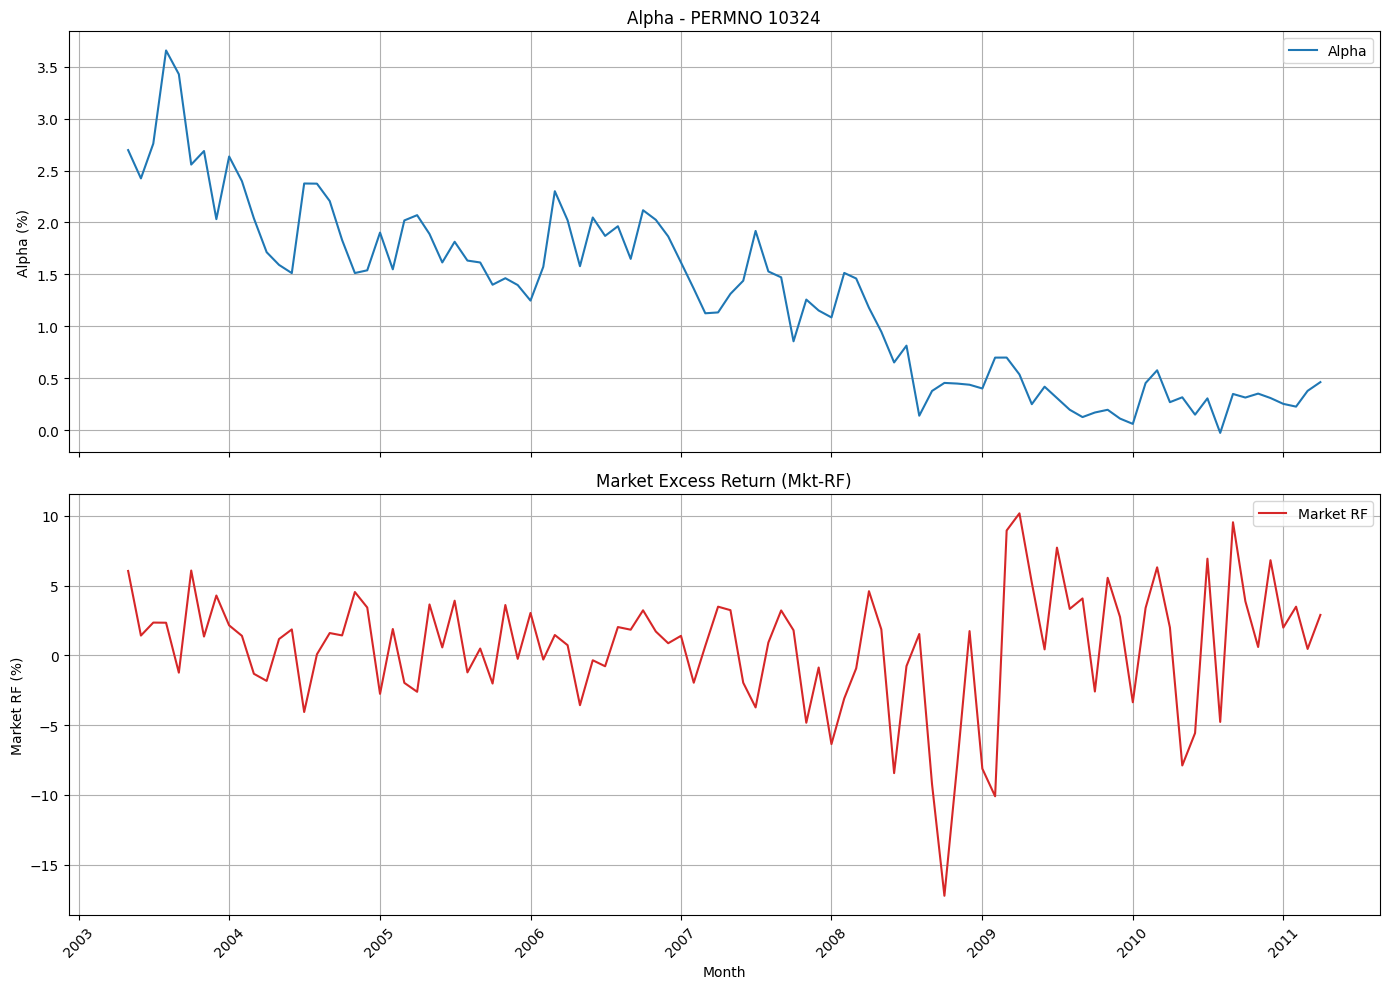

In [118]:
# Prepare data
alpha_df = result_df[result_df['PERMNO'] == 10324][['Month', 'const']]
alpha_df['const'] = alpha_df['const'] * 100  # Convert alpha to percentage

# Merge with Market RF data
plot_df = pd.merge(
    alpha_df,
    ff5_df[['Month', 'Mkt-RF']],
    on='Month',
    how='inner'
)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot Alpha
ax1.plot(plot_df['Month'], plot_df['const'], color='tab:blue', label='Alpha')
ax1.set_title('Alpha - PERMNO 10324', fontsize=12)
ax1.set_ylabel('Alpha (%)')
ax1.legend()
ax1.grid(True)

# Plot Market RF
ax2.plot(plot_df['Month'], plot_df['Mkt-RF'], color='tab:red', label='Market RF')
ax2.set_title('Market Excess Return (Mkt-RF)', fontsize=12)
ax2.set_ylabel('Market RF (%)')
ax2.legend()
ax2.grid(True)

# Formatting
plt.xticks(rotation=45)
plt.xlabel('Month')
fig.tight_layout()
plt.show()

## Task 2: Fama-MacBeth Regression

## Task 3: LASSO Regression